# Generateur de statistique sur la base des fichiers CSV de l'xp

### Imports

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob

# Chargement des CSV
folder_A = "../../output/analytics/groupe_A" # Avec touché social
folder_B = "../../output/analytics/groupe_B" # Sans touché social

### Récupération des données

In [42]:
def loadData(folder_path, groupe_label):
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    df_list = []

    for file in all_files:
        print(f"[{groupe_label}] Chargement du fichier : {file}")
        df = pd.read_csv(file, sep=',')
        
        try:
            end_time = df.loc[df['actionType'] == 'End', 'time'].astype(float).values[0]
        except IndexError:
            print(f"[{groupe_label}] Pas de ligne 'End' dans {file}")
            continue

        df['time'] = pd.to_numeric(df['time'], errors='coerce')
        df['normalizedTime'] = df['time'] / end_time
        df['source_file'] = os.path.basename(file)
        df['groupe'] = groupe_label

        df_list.append(df)

    return pd.concat(df_list, ignore_index=True) if df_list else pd.DataFrame()



# Chargement
df_A = loadData(folder_A, "Groupe A")
df_B = loadData(folder_B, "Groupe B")

# Fusion des deux
df_all = pd.concat([df_A, df_B], ignore_index=True)

[Groupe A] Chargement du fichier : ../../output/analytics/groupe_A\1751980882.csv
[Groupe A] Chargement du fichier : ../../output/analytics/groupe_A\1751982877.csv
[Groupe A] Chargement du fichier : ../../output/analytics/groupe_A\1752138156.csv
[Groupe B] Chargement du fichier : ../../output/analytics/groupe_B\1752071733.csv
[Groupe B] Chargement du fichier : ../../output/analytics/groupe_B\1752134914.csv
[Groupe B] Chargement du fichier : ../../output/analytics/groupe_B\1752141865.csv


### Formatage des données

In [43]:
stats = []
groupes = df_all['groupe'].unique()

for g in groupes:
    df_group = df_all[df_all['groupe'] == g]
    df_usertalk = df_group[df_group['actionType'] == 'UserTalk']
    df_iatalk = df_group[df_group['actionType'] == 'IATalk']
    df_walk = df_group[df_group['actionType'] == 'Walk']
    df_point = df_group[df_group['actionType'] == 'Point']
    df_end = df_group[df_group['actionType'] == 'End']

    end_times = df_end.groupby('source_file')['time'].max()
    mean_end_time = end_times.mean() if not end_times.empty else None
    nb_usertalk = len(df_usertalk)
    mean_usertalk_duration = pd.to_numeric(df_usertalk['metadata'], errors='coerce').dropna().mean()
    nb_walk = len(df_walk)
    nb_point = len(df_point)
    nb_iatalk = len(df_iatalk)
    
    stats.append({
        'Groupe': g,
        'Temps moyen End (s)': mean_end_time,
        'Nombre moyen UserTalk': nb_usertalk / len(df_end) if len(df_end) > 0 else None,
        'Durée moyenne UserTalk (s)': mean_usertalk_duration,
        'Proportion IATalk / UserTalk': (nb_iatalk / nb_usertalk) if nb_usertalk else None,
        'Proportion Walk / UserTalk': (nb_walk / nb_usertalk) if nb_usertalk else None,
        'Proportion Point / UserTalk': (nb_point / nb_usertalk) if nb_usertalk else None
    })

df_stats = pd.DataFrame(stats)

# Transposer pour avoir groupes en colonnes, stats en lignes
df_stats_T = df_stats.set_index('Groupe').T

# Vérification qu'il y a exactement 2 groupes
if df_stats_T.shape[1] == 2:
    groupe1, groupe2 = df_stats_T.columns
    df_stats_T['Différence'] = df_stats_T[groupe1] - df_stats_T[groupe2]
else:
    print("Il faut exactement 2 groupes pour calculer la différence.")

print(df_stats_T.to_string())



Groupe                          Groupe A     Groupe B  Différence
Temps moyen End (s)           668.590333  1053.493867 -384.903533
Nombre moyen UserTalk          10.000000    11.666667   -1.666667
Durée moyenne UserTalk (s)      3.073667     3.098286   -0.024619
Proportion IATalk / UserTalk    0.500000     0.800000   -0.300000
Proportion Walk / UserTalk      0.000000     0.000000    0.000000
Proportion Point / UserTalk     0.433333     0.371429    0.061905


## Graph (Temps normalisé)

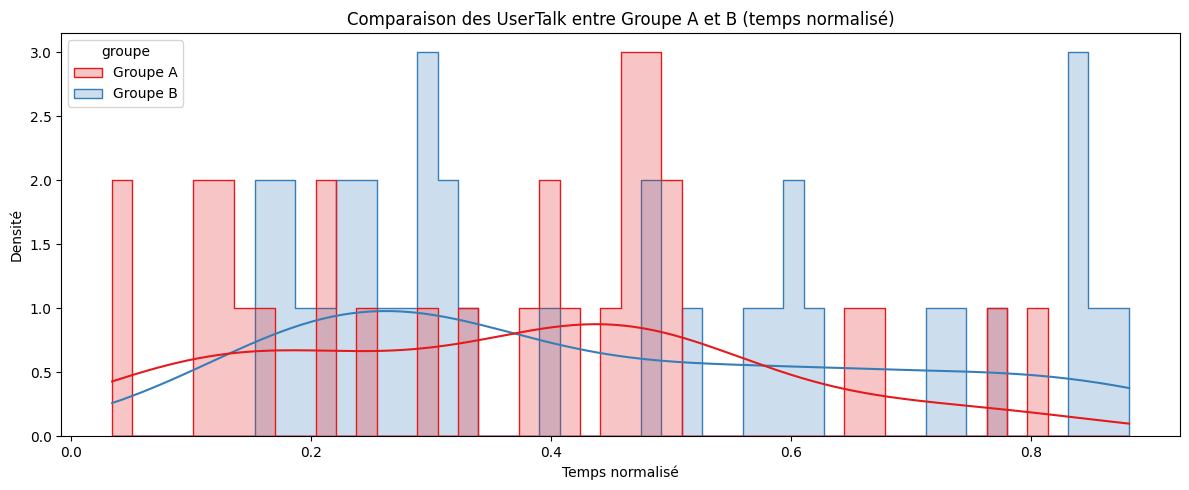

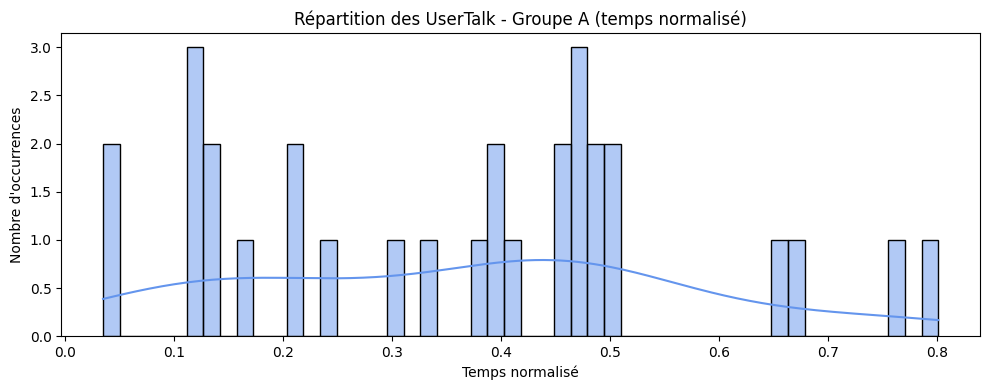

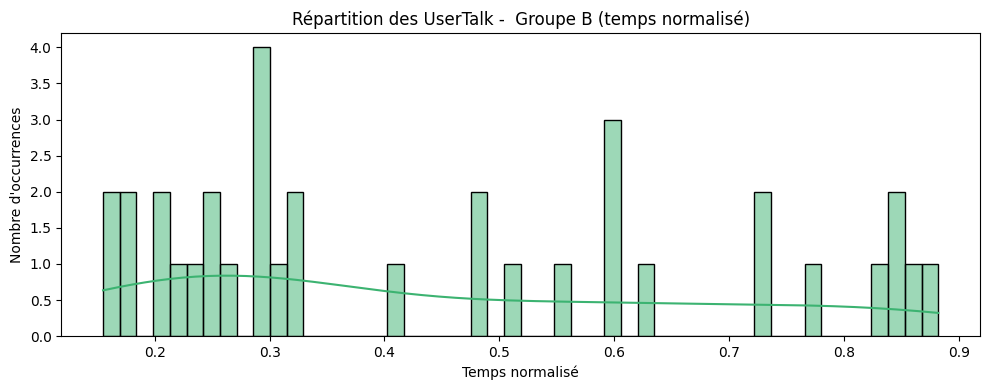

In [44]:
df_usertalk_all = df_all[df_all['actionType'] == 'UserTalk']
_bins = 50

# Graphe comparatif
plt.figure(figsize=(12, 5))
ax = sns.histplot(
    data=df_usertalk_all,
    x='normalizedTime',
    hue='groupe',
    bins=_bins,
    kde=True,
    element='step',
    common_norm=False,
    palette='Set1'
)

handles, labels = ax.get_legend_handles_labels()
if handles:
    plt.legend(handles=handles, labels=labels, title="Groupe")

plt.title("Comparaison des UserTalk entre Groupe A et B (temps normalisé)")
plt.xlabel("Temps normalisé")
plt.ylabel("Densité")
plt.tight_layout()
plt.show()

# Graphe du Groupe A
plt.figure(figsize=(10, 4))
sns.histplot(
    data=df_usertalk_all[df_usertalk_all['groupe'] == 'Groupe A'],
    x='normalizedTime',
    bins=_bins,
    kde=True,
    color='cornflowerblue'
)
plt.title("Répartition des UserTalk - Groupe A (temps normalisé)")
plt.xlabel("Temps normalisé")
plt.ylabel("Nombre d'occurrences")
plt.tight_layout()
plt.show()

# Graphe du Groupe B
plt.figure(figsize=(10, 4))
sns.histplot(
    data=df_usertalk_all[df_usertalk_all['groupe'] == 'Groupe B'],
    x='normalizedTime',
    bins=_bins,
    kde=True,
    color='mediumseagreen'
)
plt.title("Répartition des UserTalk -  Groupe B (temps normalisé)")
plt.xlabel("Temps normalisé")
plt.ylabel("Nombre d'occurrences")
plt.tight_layout()
plt.show()


## Graph (Temps réel)

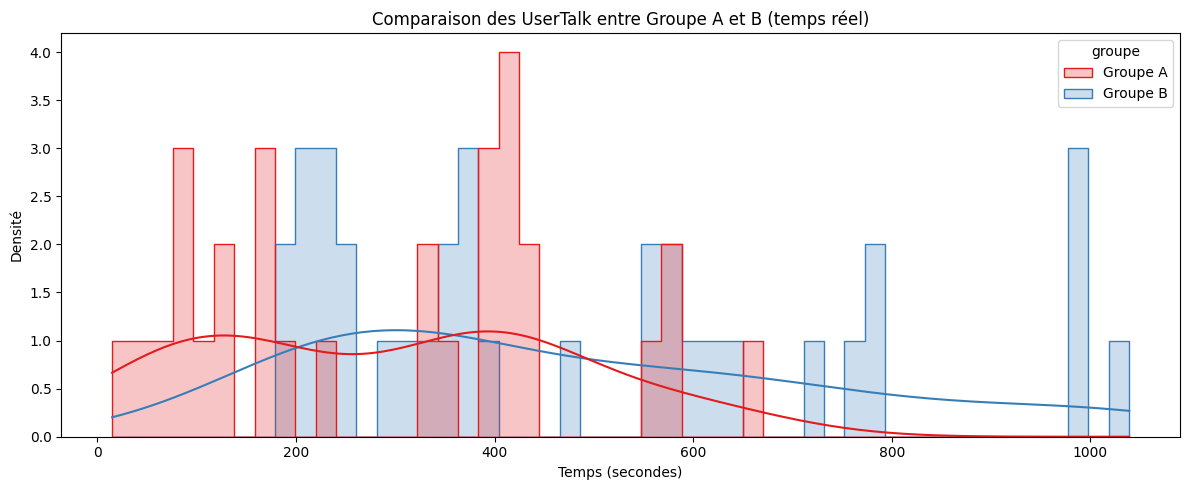

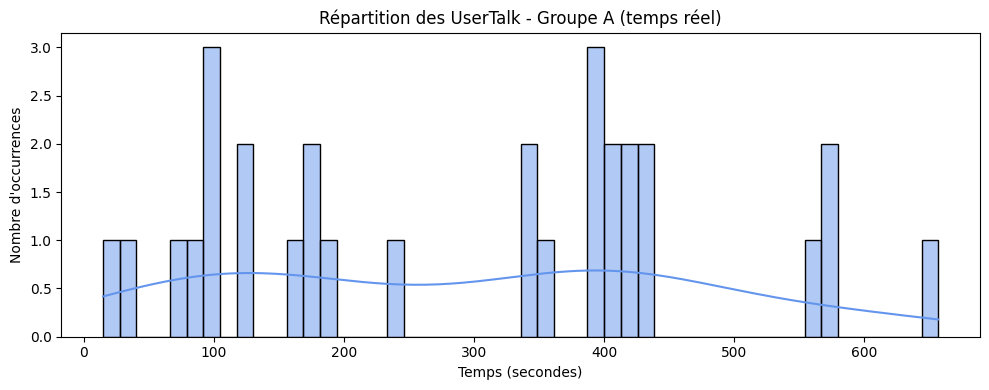

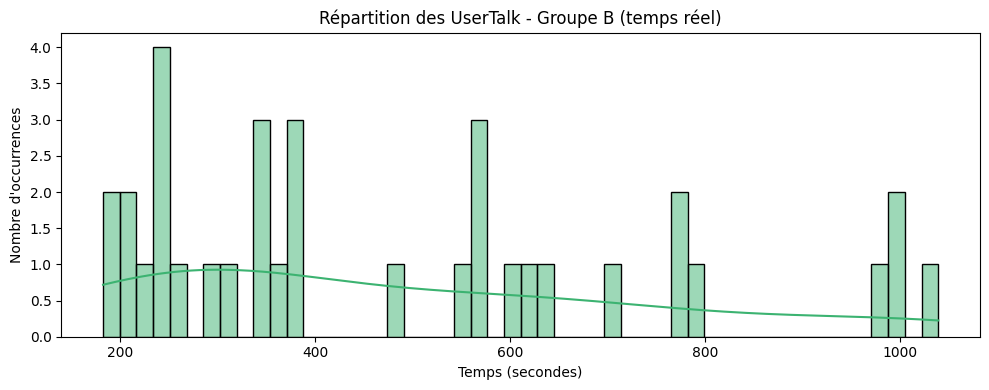

In [45]:
df_usertalk_all = df_all[df_all['actionType'] == 'UserTalk']

# Comparaison groupes - temps réel
plt.figure(figsize=(12, 5))
sns.histplot(
    data=df_usertalk_all,
    x='time',
    hue='groupe',
    bins=_bins,
    kde=True,
    element='step',
    common_norm=False,
    palette='Set1'
)
plt.title("Comparaison des UserTalk entre Groupe A et B (temps réel)")
plt.xlabel("Temps (secondes)")
plt.ylabel("Densité")
handles, labels = ax.get_legend_handles_labels()
if handles:
    plt.legend(handles=handles, labels=labels, title="Groupe")
plt.tight_layout()
plt.show()

# Groupe A - temps réel
plt.figure(figsize=(10, 4))
sns.histplot(
    data=df_usertalk_all[df_usertalk_all['groupe'] == 'Groupe A'],
    x='time',
    bins=_bins,
    kde=True,
    color='cornflowerblue'
)
plt.title("Répartition des UserTalk - Groupe A (temps réel)")
plt.xlabel("Temps (secondes)")
plt.ylabel("Nombre d'occurrences")
plt.tight_layout()
plt.show()

# Groupe B - temps réel
plt.figure(figsize=(10, 4))
sns.histplot(
    data=df_usertalk_all[df_usertalk_all['groupe'] == 'Groupe B'],
    x='time',
    bins=_bins,
    kde=True,
    color='mediumseagreen'
)
plt.title("Répartition des UserTalk - Groupe B (temps réel)")
plt.xlabel("Temps (secondes)")
plt.ylabel("Nombre d'occurrences")
plt.tight_layout()
plt.show()